In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
%matplotlib inline

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
DATA_PATH = "data"
os.chdir(DATA_PATH)
%run download.py

Downloading...

Extracting...
Extracting successfully done to C:\Users\Ekele\Desktop\TransferLearning\data\hymenoptera_data.
Current directory C:\Users\Ekele\Desktop\TransferLearning


In [5]:
DATASET_PATH = os.path.join(DATA_PATH, "hymenoptera_data")
 
print("\n" + "hymenoptera_data Dataset is now located at {}".format(DATASET_PATH))
os.listdir(DATASET_PATH)


hymenoptera_data Dataset is now located at data\hymenoptera_data


['train', 'val']

In [6]:
os.getcwd()

'C:\\Users\\Ekele\\Desktop\\TransferLearning'

In [8]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

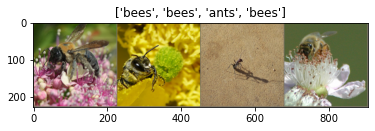

In [13]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, 
                                                        time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Ekele/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:06<00:00, 7.00MB/s]


In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6490 Acc: 0.6885
val Loss: 0.1594 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4817 Acc: 0.8115
val Loss: 0.2491 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4239 Acc: 0.8361
val Loss: 0.3877 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4675 Acc: 0.8402
val Loss: 0.4368 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.6079 Acc: 0.8115
val Loss: 0.2944 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4923 Acc: 0.8320
val Loss: 0.5136 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.8370 Acc: 0.6967
val Loss: 0.3156 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3161 Acc: 0.8566
val Loss: 0.2591 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2482 Acc: 0.9057
val Loss: 0.2730 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.4015 Acc: 0.8361
val Loss: 0.2627 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2216 Acc: 0.8852
val Loss: 0.2548 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2566 Acc: 0.9057
val Loss: 0.2493 Acc: 0.8954

Ep

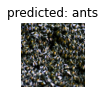

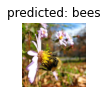

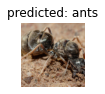

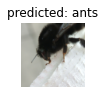

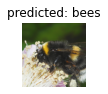

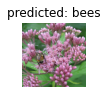

In [18]:
visualize_model(model_ft)

## Transfer Learning

In [19]:
model_conv = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Ekele/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:16<00:00, 6.34MB/s]


In [20]:
for param in model_conv.parameters():
    param.requires_grad = False

In [22]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
                      num_epochs=25)

Epoch 0/24
----------


C:\Users\Ekele\Anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4117 Acc: 0.8156
val Loss: 0.1840 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4511 Acc: 0.7992
val Loss: 0.2117 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3958 Acc: 0.8197
val Loss: 0.1731 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4054 Acc: 0.8156
val Loss: 0.1620 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3750 Acc: 0.8279
val Loss: 0.2310 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3992 Acc: 0.8484
val Loss: 0.1681 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3759 Acc: 0.8279
val Loss: 0.1936 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4240 Acc: 0.8115
val Loss: 0.1795 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4498 Acc: 0.7910
val Loss: 0.1733 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4634 Acc: 0.7992
val Loss: 0.1669 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3683 Acc: 0.8484
val Loss: 0.1653 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.4020 Acc: 0.7951
val Loss: 0.1654 Acc: 0.9346

Epoch 12/24
----------
t

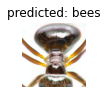

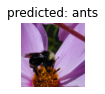

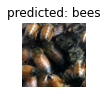

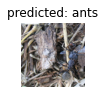

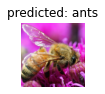

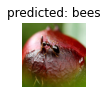

In [24]:
visualize_model(model_conv)

In [25]:
plt.ioff()

In [26]:
plt.show()